### Yelp Bussiness Clustering

Our goal is to group the companies from Toronto using the text of the reviews they receive. To evaluate clustering we will use the business category.

Download dataset from: https://www.yelp.com/dataset

First we read the business file and pass it to a pandas dataframe. Then we prune the data to keep the companies from the city of Toronto that have the category "Beauty & Spas", "Shopping" and "Bars" in their categories (for companies that have all three categories, we assigned the company in a category with the above order of priority). We kept companies that have at least 10 reviews. For our convenience we have created 4 lists where each one has as values the ids of the companies for each category separately, in this way we can merge the lists to have in the first places the companies that have all 3 fields, in the following positions businesses such as Bars etc (ie to sort our final list by fields).

In [1]:
import numpy as np
import json
import pandas as pd
from pandas import DataFrame
import ijson


t=0
businessList =[]
tempCategoriesList = []
businessDict = {}
businessListBeauty = []
businessListBars = []
businessListShopping = []
businessListPriority = []

with open('yelp_academic_dataset_business.json', encoding='utf-8',errors = 'ignore') as fh:
    print("Read file...")
    jSonReaderB = pd.read_json(fh,lines=True)
    print("loading file to a dataframe...")
    dfBusiness = DataFrame(jSonReaderB, columns= ['city', 'review_count','business_id','stars','categories'])

    print("file Loaded!")
    print("Pruning data...")
    for index, row in dfBusiness.iterrows():
        flag = False
        categories = row['categories']
        if categories is not None:
            tempCategoriesList = categories.split(', ')
               

        typeBusiness = ''
        for item in tempCategoriesList:
            if item == 'Beauty & Spas' or item == 'Shopping' or item == 'Bars':
                typeBusiness = item + typeBusiness
                flag = True

        
        if (row['city'] == 'Toronto' and flag is True and row['review_count']>9):

            
            if typeBusiness == 'Beauty & Spas' or typeBusiness == 'Beauty & SpasShopping' or typeBusiness == 'Beauty & SpasBars':
                businessListBeauty.append(row['business_id'])
                
            elif typeBusiness == 'Shopping' or typeBusiness == 'ShoppingBars' or typeBusiness == 'ShoppingBeauty & Spas' :
                businessListShopping.append(row['business_id'])
            elif typeBusiness == 'Bars' or typeBusiness == 'BarsBeauty & Spas' or typeBusiness == 'BarsShopping' : 
                businessListBars.append(row['business_id'])
            else:
                businessListPriority.append(row['business_id'])
                
    #Merge the lists (we did that to sort the bussinesses in a way that the bussinesses with the 3 categories be in the begginening of the array)
    businessList = businessListPriority + businessListBeauty + businessListShopping + businessListBars

    print("Total categories:")
    print("Busineswith the 3 categories: ",len(businessListPriority))
    print("Business with type Beauty: ", len(businessListBeauty))
    print("Business with type Shopping: ",len(businessListShopping))
    print("Business with type Bars: ",len(businessListBars))
    for item in businessList:
        businessDict[item] = []

    print("Total length:",len(businessList))
 
    



Read file...
loading file to a dataframe...
file Loaded!
Pruning data...
Total categories:
Busineswith the 3 categories:  0
Business with type Beauty:  776
Business with type Shopping:  944
Business with type Bars:  1271
Total length: 2991


Then after we have made the list of business Ids we open the file reviews and stream its data with the ijson library. We create a dictionary that has business ids for keys and a list of strings for values. The strings are the reviews that correspond to each company.

In [2]:
import ijson

t =0
flag == False
with open('yelp_academic_dataset_review.json', encoding='utf-8',errors = 'ignore') as input_file:
 
        parser = ijson.parse(input_file,multiple_values=True)
        for prefix, event, value in parser:           
            t = t +1
           
            if(prefix=='business_id'):
                current_busiID = value
                
                if current_busiID in businessDict:
                    flag = True
                    
            if (prefix=='text' and flag==True ):
                

                businessDict[current_busiID].append(value)
                flag = False


In this step we convert each list from strings to a single string and put it in a new list (business ratings)

In [3]:

businessRatings = []
for key in businessDict:
    
    
    listTostring = "".join(businessDict[key])

    businessRatings.append(listTostring)

At this point we calculate the tf-idf and create the true_labels list

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sn
import sklearn.feature_extraction.text as sk_text

vectorizer = sk_text.TfidfVectorizer(stop_words = 'english',min_df=1)
X = vectorizer.fit_transform(businessRatings)
print(X.toarray())
print(X.shape)

#true_labels
true_labels1 =[]
true_labels2 =[]
true_labels3 =[]

#776 beauty
#944 shopping
#1271 bars
for i in range(len(businessListBeauty)):
    true_labels1.append(0)
for i in range(len(businessListShopping)):
    true_labels2.append(1)
for i in range(len(businessListBars)):
    true_labels3.append(2)
true_labes = []
true_labels = true_labels1 + true_labels2  + true_labels3



[[0.01192102 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(2991, 98318)


In [5]:

def create_confusion_matrix(kmeans_labels, true_labels, ticklabels):
    C= metrics.confusion_matrix(kmeans_labels,true_labels)
    mapping = list(np.argmax(C,axis=1))
    mapped_kmeans_labels = [mapping[l] for l in kmeans_labels]
    C2= metrics.confusion_matrix(mapped_kmeans_labels,true_labels)
    print (C2)
    
    plt.figure(figsize = (10,7))
    ax = sn.heatmap(C2,  xticklabels=ticklabels, yticklabels=ticklabels, annot=True, cmap="Reds", fmt='g')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

    calculate_precision_recall(true_labels, mapped_kmeans_labels)
    
    return C2

def calculate_precision_recall(true_labels, kmeans_labels):
    p = metrics.precision_score(true_labels, kmeans_labels, average=None)
    print('Precision : ', p)
    r = metrics.recall_score(true_labels, kmeans_labels, average = None)
    print('Recall :', r)

def kmeans_cluster(matrix,numOfClusters):

    kmeans = sk_cluster.KMeans(init='k-means++', n_clusters=numOfClusters, n_init=10)
    kmeans.fit_predict(matrix)
    centroids = kmeans.cluster_centers_
    kmeans_labels = kmeans.labels_
    error = kmeans.inertia_
    print ("The total error of the clustering is: ", error)
    print ('\nCluster labels')
    print(len(kmeans_labels))
    print(kmeans_labels)

    print ('\n Cluster Centroids')
    print (centroids)
    print('\n Total centroids: ', len(centroids[0]))

    
    return kmeans


The total error of the clustering is:  2449.6941269773156

Cluster labels
2991
[1 1 1 ... 0 0 0]

 Cluster Centroids
[[3.87319103e-03 3.89683107e-04 7.94515617e-06 ... 7.38039996e-07
  5.03695803e-05 0.00000000e+00]
 [2.92824496e-03 1.32293090e-03 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 3.27432970e-05]
 [5.25045893e-03 7.02860525e-05 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]

 Total centroids:  98318
[[ 211    3    0]
 [ 563  911   99]
 [   2   30 1172]]


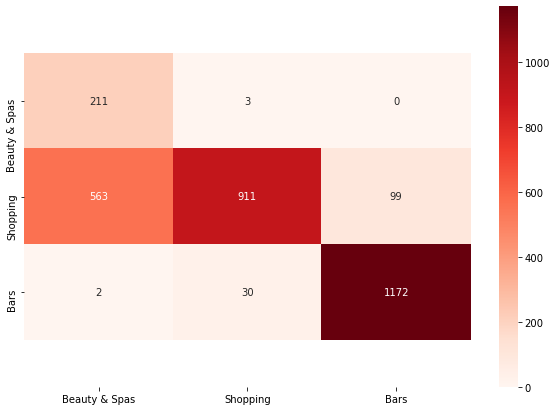

Precision :  [0.98598131 0.57914812 0.97342193]
Recall : [0.27190722 0.96504237 0.92210858]


In [6]:
import sklearn.feature_extraction.text as sk_text
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import sklearn.cluster as sk_cluster

matrix = X
kmeans = kmeans_cluster(matrix, 3)

topics =['Beauty & Spas','Shopping','Bars']
C = create_confusion_matrix(kmeans.labels_, true_labels, topics)



In [7]:
def aggloCluster(linkAge,matrix):
    
    agglo = sk_cluster.AgglomerativeClustering(linkage=linkAge, n_clusters = 3)
    agglo_labels = agglo.fit_predict(matrix.toarray())


    C_agglo= metrics.confusion_matrix(agglo_labels,true_labels)

    mapping = list(np.argmax(C_agglo,axis=1))
    mapped_agglo_labels = [mapping[l] for l in agglo.labels_]
    C2_agglo = metrics.confusion_matrix(mapped_agglo_labels,true_labels)

    ax = sn.heatmap(C2_agglo, cmap='Blues', xticklabels = topics, yticklabels=topics, fmt='g', annot=True)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

    calculate_precision_recall(true_labels, mapped_agglo_labels)

    return C2_agglo


linkage = ward


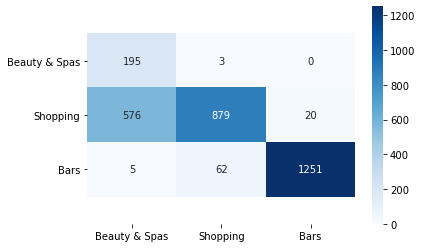

Precision :  [0.98484848 0.5959322  0.9491654 ]
Recall : [0.25128866 0.93114407 0.98426436]
linkage = single


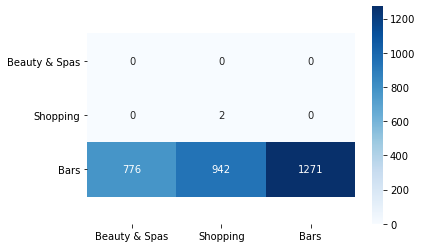

C:\Users\giwrg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision :  [0.         1.         0.42522583]
Recall : [0.         0.00211864 1.        ]
linkage = complete -link


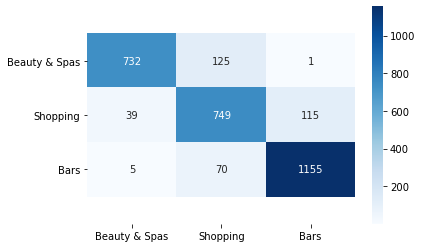

Precision :  [0.85314685 0.82945736 0.93902439]
Recall : [0.94329897 0.7934322  0.90873328]
linkage = average


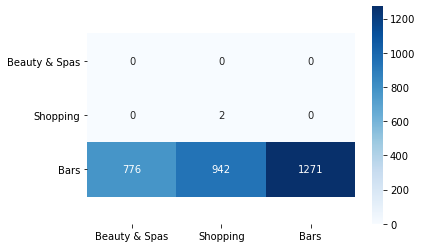

Precision :  [0.         1.         0.42522583]
Recall : [0.         0.00211864 1.        ]


C:\Users\giwrg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
matrix = X
print('linkage = ward')
C2_agglo = aggloCluster('ward',matrix)
print('linkage = single')
C2_agglo = aggloCluster('single',matrix)
print('linkage = complete -link')
C2_agglo = aggloCluster('complete',matrix)
print('linkage = average')
C2_agglo = aggloCluster('average',matrix)

**Conclusion**

We observe that agglomerative with linkage = complete -link has the best values in precision while with linkage = average and linkage = single they have the worst.

For linkage = ward we observe that there is a small precision in beauty and spas companies, so they are incorrectly passed to the shopping category.

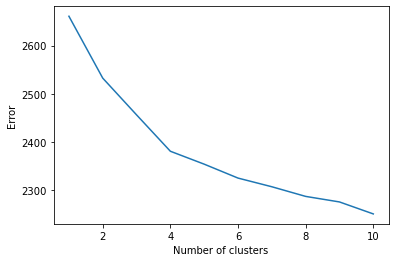

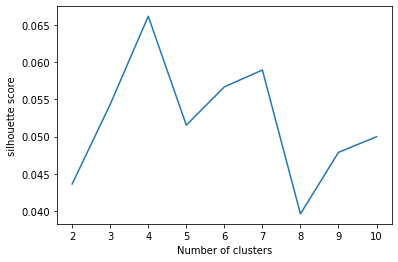

In [9]:
error = np.zeros(11)
sh_score = np.zeros(11)
for k in range(1,11):
    kmeans = sk_cluster.KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit_predict(X)
    error[k] = kmeans.inertia_
    if k>1: sh_score[k]= metrics.silhouette_score(X, kmeans.labels_)

plt.plot(range(1,len(error)),error[1:])
plt.xlabel('Number of clusters')
plt.ylabel('Error')
plt.show()

plt.plot(range(2,len(sh_score)),sh_score[2:])
plt.xlabel('Number of clusters')
plt.ylabel('silhouette score')
plt.show()


To find the ideal number of clusters we must have a high silhouette score and in the SSE plot there must be the so-called "knee" in the corresponding number of clusters. Here it is observed that this number is 4.

So now for k = 4 I run the k-means algorithm again.

The total error of the clustering is:  2380.4036727877638

Cluster labels
2991
[2 3 2 ... 1 1 1]

 Cluster Centroids
[[5.22603819e-03 6.99591406e-05 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.87143825e-03 3.84987797e-04 8.19004113e-06 ... 7.60787804e-07
  5.19220673e-05 0.00000000e+00]
 [2.93867898e-03 1.53539067e-03 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 3.83508609e-05]
 [3.02251158e-03 1.45107035e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]

 Total centroids:  98318
[[ 465   15    0]
 [ 309  901  133]
 [   2   28 1138]]


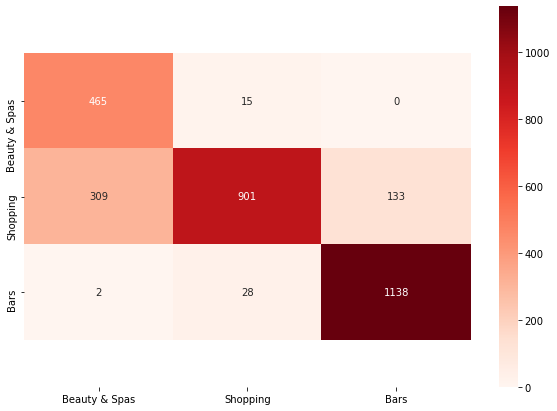

Precision :  [0.96875    0.67088608 0.97431507]
Recall : [0.5992268  0.95444915 0.89535799]


In [10]:
matrix = X
kmeans = kmeans_cluster(matrix, 4)

kmeans_labels = kmeans.labels_
C = create_confusion_matrix(kmeans.labels_, true_labels, topics)

**Conclusion**

For k = 4 we get better values in Precision and recall. So the ideal number k is 4. Compared to agglomerative with linkage = complete - link, kmean has a much worse score in the precision (which concerns the shopping category) while in the other 2 categories it has slightly better than the agglomerative. So we conclude that agglomerative is better because it has a smaller score gap.